In [1]:
import h5py
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
def load_gigapath_embeddings(output_dir, prefix="lunghist700_global_pool_True_"):
    """
    Load GigaPath embeddings and metadata from the output directory.
    
    Args:
        output_dir: Path to the directory containing embedding files
        prefix: Prefix used when generating the files (including global_pool setting)
        
    Returns:
        dict: Dictionary containing slide embeddings, tile embeddings, and metadata
    """
    output_dir = Path(output_dir)
    
    # Load slide-level WSI embeddings
    wsi_path = output_dir / f"{prefix}wsi_embeddings.h5"
    with h5py.File(wsi_path, 'r') as f:
        wsi_embeddings = np.array(f['embeddings'])
    
    # Load metadata to map indices to image names
    metadata_path = output_dir / f"{prefix}metadata.csv"
    metadata = pd.read_csv(metadata_path)
    
    # Load tile-level embeddings (organized by image)
    tile_path = output_dir / f"{prefix}tile_embeddings.h5"
    tile_embeddings = {}
    with h5py.File(tile_path, 'r') as f:
        for img_name in f.keys():
            tile_embeddings[img_name] = {
                'embeddings': np.array(f[img_name]['embeddings']),
                'coordinates': np.array(f[img_name]['coordinates'])
            }
    
    return {
        'wsi_embeddings': wsi_embeddings,
        'metadata': metadata,
        'tile_embeddings': tile_embeddings
    }


In [3]:
project_root = Path(".").resolve().parent

In [4]:
project_root

PosixPath('/home/valentin/workspaces/histopatseg')

In [5]:
# Load embeddings with global pooling True
embeddings_true = load_gigapath_embeddings(
    project_root/"data/processed/LungHist700_embeddings/gigapath/",
    prefix="lunghist700_global_pool_True_"
)

# Load embeddings with global pooling False 
embeddings_false = load_gigapath_embeddings(
    project_root/"data/processed/LungHist700_embeddings/gigapath/",
    prefix="lunghist700_global_pool_False_"
)

# Now you can work with the embeddings
print(f"Number of WSIs: {len(embeddings_true['metadata'])}")
print(f"WSI embedding shape: {embeddings_true['wsi_embeddings'].shape}")



Number of WSIs: 691
WSI embedding shape: (691, 768)


In [6]:
# Load original dataset metadata
metadata_path = project_root / "data/processed/LungHist700/metadata.csv"
original_metadata = pd.read_csv(metadata_path)

# Create a mapping from filename to class_name
filename_to_class = dict(zip(original_metadata['filename'], original_metadata['class_name']))

In [7]:
# Get WSI embeddings and metadata
wsi_embeddings = embeddings_false['wsi_embeddings'] 
metadata = embeddings_false['metadata']

# Add class information from original metadata
image_names = metadata['image_name'].tolist()
classes = []
superclasses = []  # New list for superclasses
for name in image_names:
    # Extract the filename part without extension
    base_name = name
    # Try to match with the original metadata
    if base_name in filename_to_class:
        full_class = filename_to_class[name]
        classes.append(full_class)
        # Extract superclass (first part before underscore)
        superclass = full_class.split('_')[0]
        superclasses.append(superclass)
    else:
        print(f"Warning: {name} not found in original metadata.")
        classes.append('unknown')
        superclasses.append('unknown')

metadata['class_name'] = classes
metadata['superclass'] = superclasses  # Add superclass column

In [8]:
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(wsi_embeddings)-1))
tsne_result = tsne.fit_transform(wsi_embeddings)

In [9]:
# Create a DataFrame for easy plotting
tsne_df = pd.DataFrame({
    'tsne_1': tsne_result[:, 0],
    'tsne_2': tsne_result[:, 1],
    'class': metadata['class_name'],
    'superclass': metadata['superclass'],  # Include superclass
    'image_name': metadata['image_name']
})

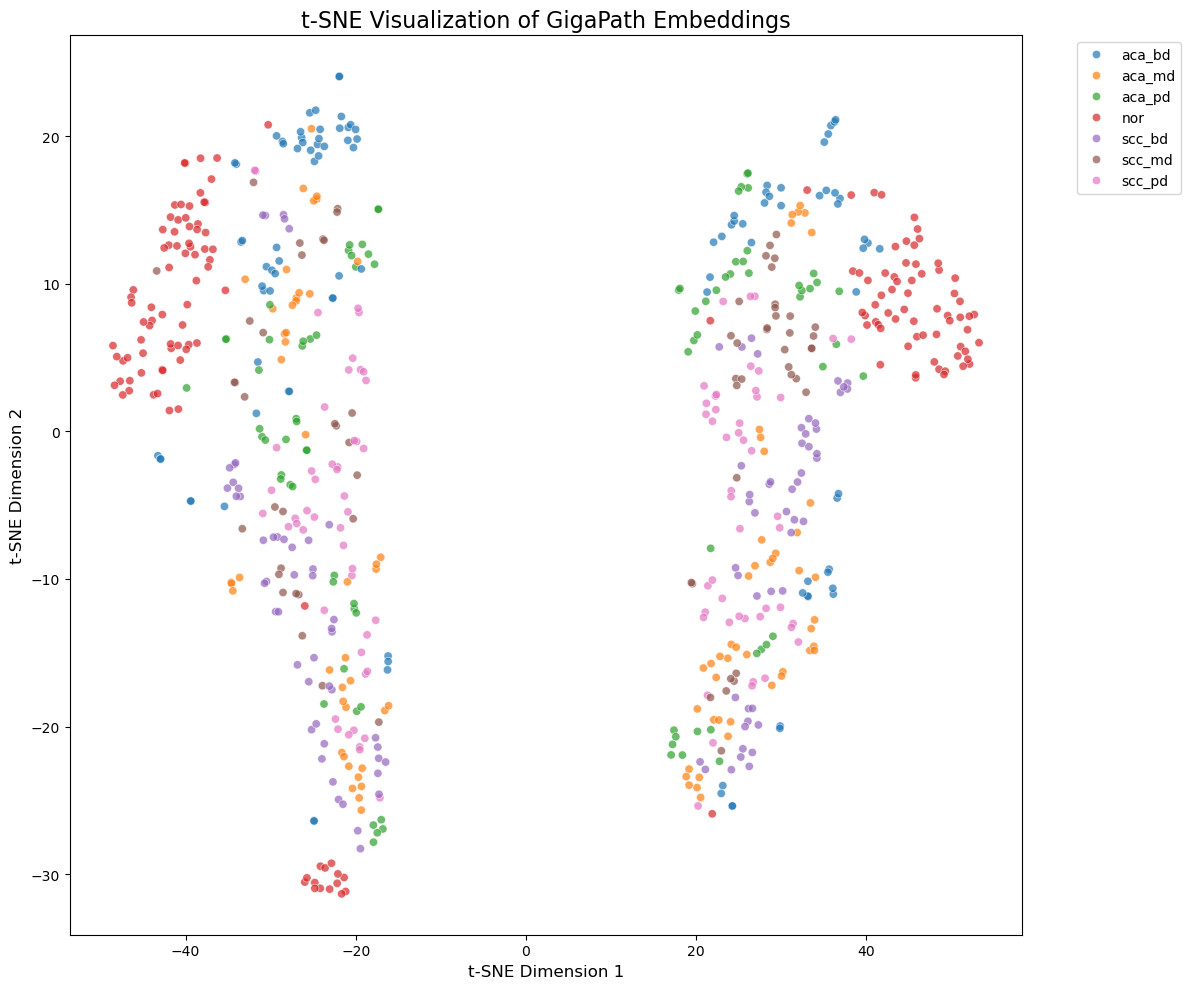

In [10]:
# Plot with Seaborn - with sorted legend
plt.figure(figsize=(12, 10))

# Get unique classes and sort them alphabetically
sorted_classes = sorted(tsne_df['class'].unique())

# Create a custom color palette with consistent colors for sorted classes
palette = dict(zip(sorted_classes, sns.color_palette("tab10", len(sorted_classes))))

# Create plot with custom hue order
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='class',
    hue_order=sorted_classes,  # This ensures alphabetical order in legend
    palette=palette,
    data=tsne_df,
    legend='full',
    alpha=0.7
)

plt.title('t-SNE Visualization of GigaPath Embeddings', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# plt.savefig(project_root / "reports/figures/gigapath/LungHist700_pool_True_tsne_visualization.png", dpi=300, bbox_inches='tight')

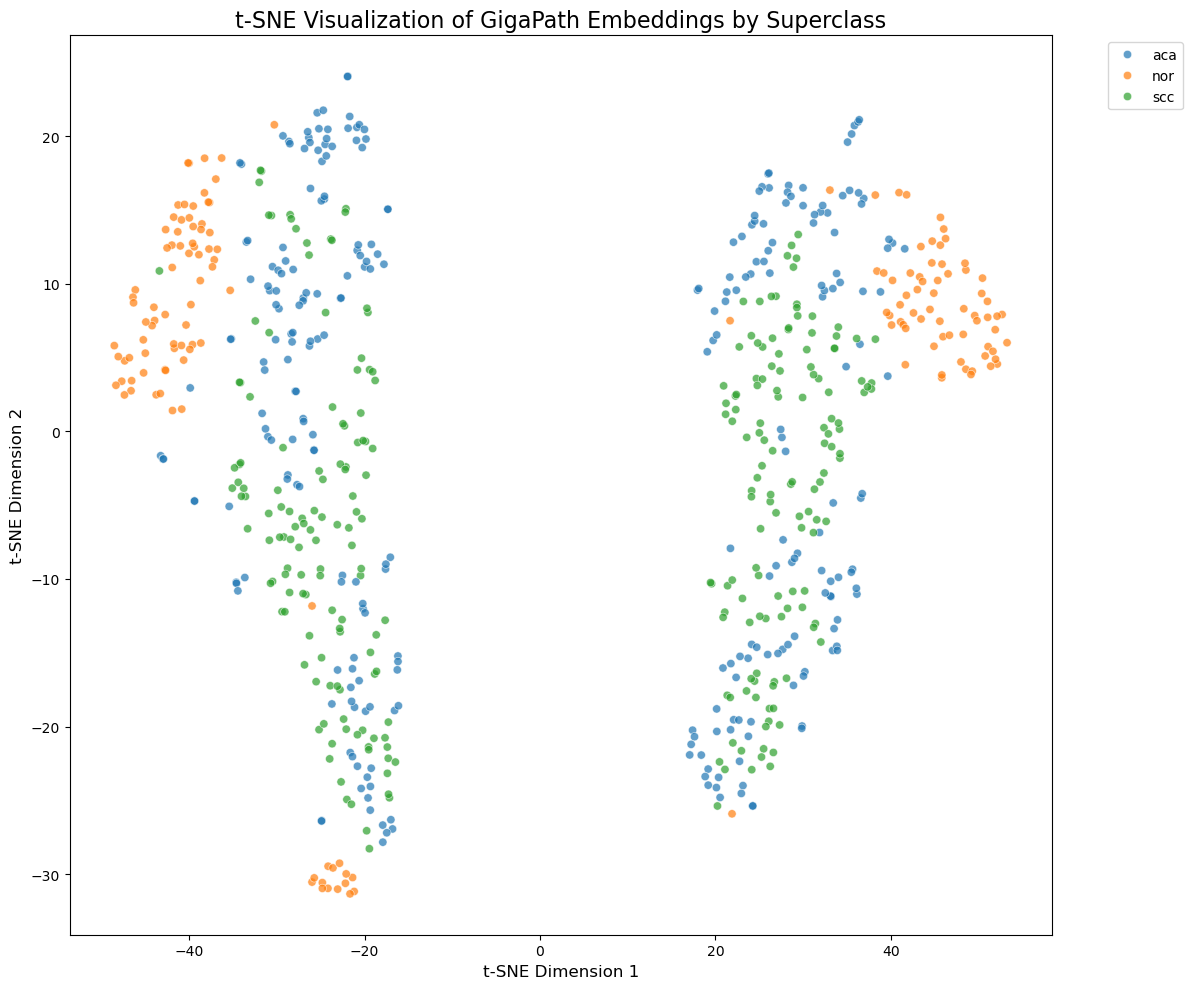

In [12]:
# Plot with Seaborn - with sorted legend and using superclass
plt.figure(figsize=(12, 10))

# Get unique superclasses and sort them alphabetically
sorted_superclasses = sorted(tsne_df['superclass'].unique())

# Create a custom color palette with consistent colors for sorted classes
palette = dict(zip(sorted_superclasses, sns.color_palette("tab10", len(sorted_superclasses))))

# Create plot with custom hue order using superclass
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='superclass',  # Use superclass instead of class
    hue_order=sorted_superclasses,  # This ensures alphabetical order in legend
    palette=palette,
    data=tsne_df,
    legend='full',
    alpha=0.7
)

plt.title('t-SNE Visualization of GigaPath Embeddings by Superclass', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [11]:
# Save the plot with superclass
# plt.savefig(project_root / "reports/figures/gigapath/LungHist700_pool_True_tsne_superclass.png", dpi=300, bbox_inches='tight')